In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, homogeneity_score, accuracy_score
import matplotlib.cm as cm
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import FastICA
import warnings

# Load the dataset
wine_dataset = load_wine()

# Access the feature names
feature_names = wine_dataset.feature_names

# Access the data and target
data = wine_dataset.data
target = wine_dataset.target

# Convert data and target to a Pandas DataFrame
wine_df = pd.DataFrame(data, columns=feature_names)
wine_df['target'] = target

np.random.seed(42)

print(wine_df.info())
print(wine_df.shape)

# Normalize features for better performance
min_max_scaler = MinMaxScaler()
wineX = min_max_scaler.fit_transform(wine_df.drop("target", axis=1).values)
wineY = wine_df["target"].values

# Perform a stratified split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(wineX, wineY, test_size=0.2, stratify=wineY, random_state=42)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178 entries, 0 to 177
Data columns (total 14 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   alcohol                       178 non-null    float64
 1   malic_acid                    178 non-null    float64
 2   ash                           178 non-null    float64
 3   alcalinity_of_ash             178 non-null    float64
 4   magnesium                     178 non-null    float64
 5   total_phenols                 178 non-null    float64
 6   flavanoids                    178 non-null    float64
 7   nonflavanoid_phenols          178 non-null    float64
 8   proanthocyanins               178 non-null    float64
 9   color_intensity               178 non-null    float64
 10  hue                           178 non-null    float64
 11  od280/od315_of_diluted_wines  178 non-null    float64
 12  proline                       178 non-null    float64
 13  targe

       IC_1      IC_2      IC_3      IC_4      IC_5      IC_6      IC_7  \
0 -1.290460  0.123022 -2.249834 -0.936114  0.673434 -1.195570  0.244677   
1  0.219012  0.010563  0.211454 -0.618392 -0.250929  0.688422  0.356240   
2 -0.258803 -1.398117 -1.311997 -0.810221  0.716113 -0.056892 -1.017631   
3  0.032778 -0.233132 -0.105888  0.371506  0.459827 -0.517902 -0.740274   
4  0.155507 -0.795889  0.437001  0.649600 -1.403429  0.198132  0.512329   

       IC_8      IC_9     IC_10     IC_11     IC_12     IC_13  
0  0.640916  0.814295 -0.356402  0.450097  1.359926 -0.097820  
1 -2.366496  0.090128 -1.980699  0.420849 -0.341845 -1.391124  
2 -0.579300  1.490662 -0.236334  0.034145  0.239341  0.281819  
3 -2.300784  0.828084 -0.698944  0.054921  0.473301 -0.451548  
4  0.053617  0.531527 -0.480986 -0.853069  0.036548  0.634906  


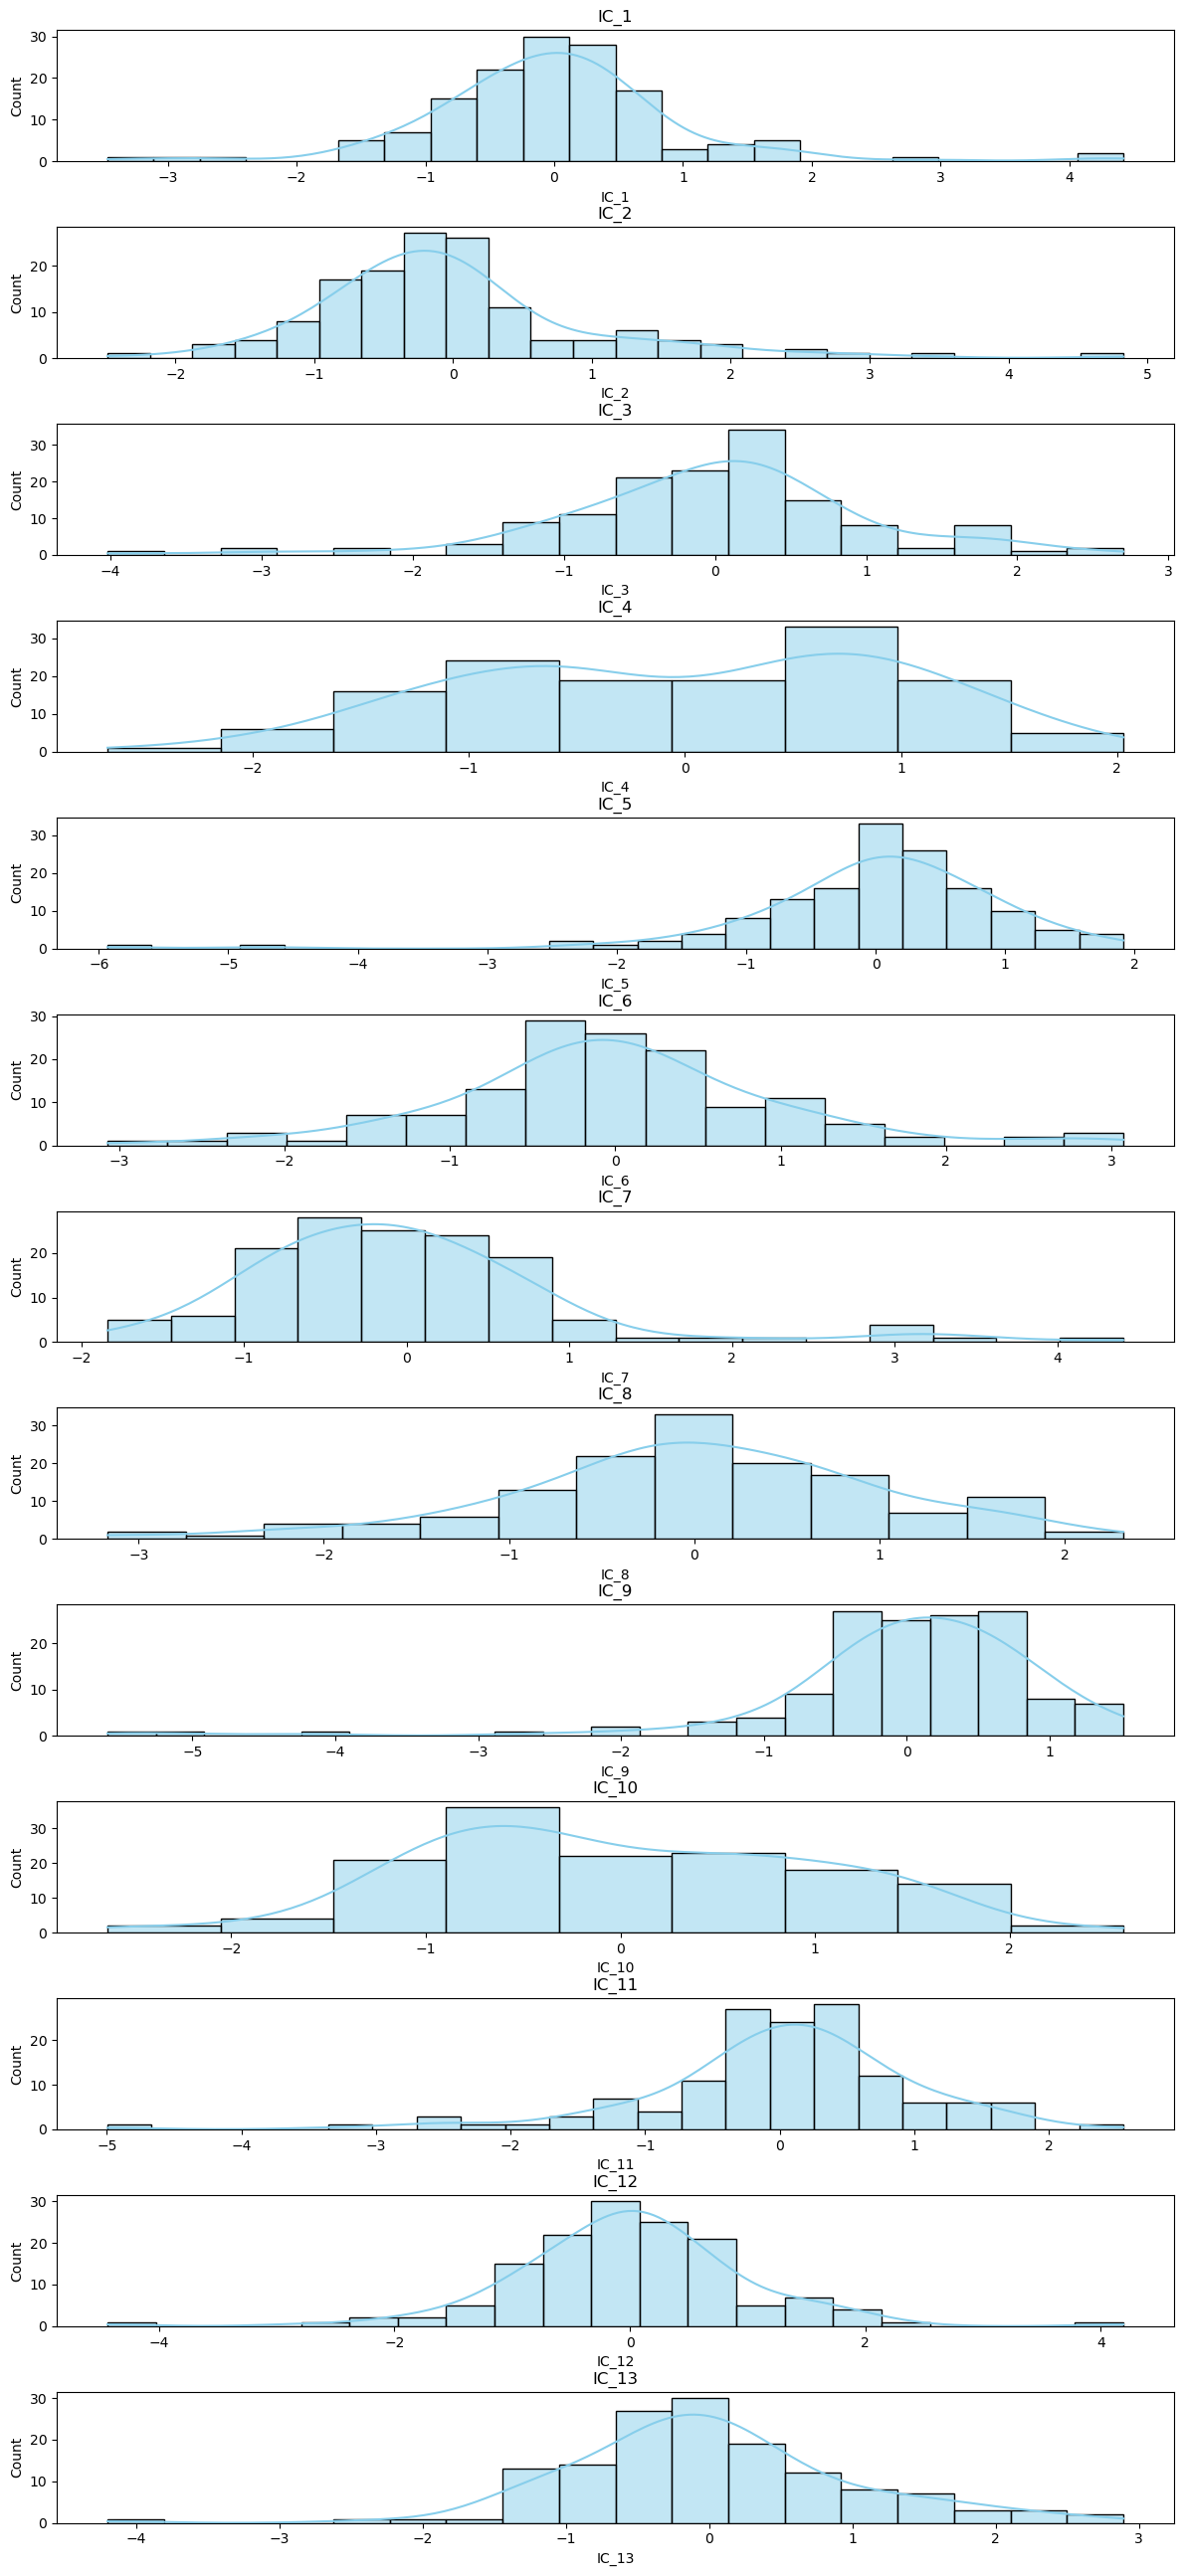

In [3]:
from sklearn.decomposition import FastICA

with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=FutureWarning)
    
    # Number of components to extract - you can adjust this number based on your needs
    n_components = X_train.shape[1]

    # Perform ICA
    ica = FastICA(n_components=n_components, random_state=42, max_iter=2000, tol=0.01)

    X_train_ICA = ica.fit_transform(X_train)

    # Convert the ICA-transformed data into a DataFrame for better visualization
    ica_df = pd.DataFrame(X_train_ICA, columns=[f'IC_{i+1}' for i in range(n_components)])

    print(ica_df.head())

    #Plot the independent components to visualize their distributions
    plt.figure(figsize=(12, 2 * n_components))  # Increase the vertical size of the plot
    for i, col in enumerate(ica_df.columns):
        plt.subplot(n_components, 1, i + 1)
        sns.histplot(ica_df[col], kde=True, color='skyblue')
        plt.title(col)
        plt.tight_layout()

    # If the UserWarning persists, try adjusting the subplots layout like this:
    plt.subplots_adjust(hspace=0.5)  # Adjust horizontal spacing
    plt.show()

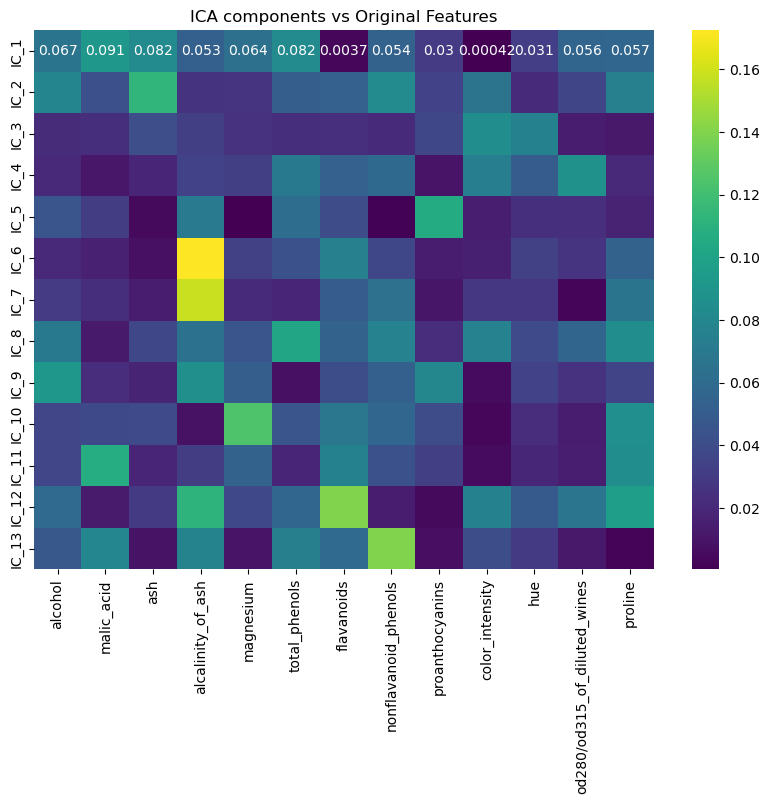

In [4]:
# Create a heatmap for ICA components vs original features
plt.figure(figsize=(10, 7))
sns.heatmap(abs(ica.mixing_), cmap='viridis', annot=True, yticklabels=[f'IC_{i+1}' for i in range(n_components)], xticklabels=feature_names)
plt.title('ICA components vs Original Features')
plt.show()

In [5]:
# Model trained on ICA components
clf_ica = DecisionTreeClassifier(random_state=42)
clf_ica.fit(X_train_ICA, y_train)
y_pred_ica = clf_ica.predict(ica.transform(X_test))
print(f"Accuracy (ICA): {accuracy_score(y_test, y_pred_ica)*100:.2f}%")

# Model trained on original data
clf = DecisionTreeClassifier(random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(f"Accuracy (Original): {accuracy_score(y_test, y_pred)*100:.2f}%")

Accuracy (ICA): 75.00%
Accuracy (Original): 94.44%


In [6]:
# Reconstruction
X_train_ICA_reconstructed = ica.inverse_transform(X_train_ICA)
reconstruction_error = mean_squared_error(X_train, X_train_ICA_reconstructed)
print(f"Reconstruction error: {reconstruction_error}")

Reconstruction error: 5.739573790982451e-32


/Users/yrizvi/miniconda3/envs/ML/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/yrizvi/miniconda3/envs/ML/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/yrizvi/miniconda3/envs/ML/lib/python3.9/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)
/Users/yrizvi/miniconda3/envs/ML/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinst

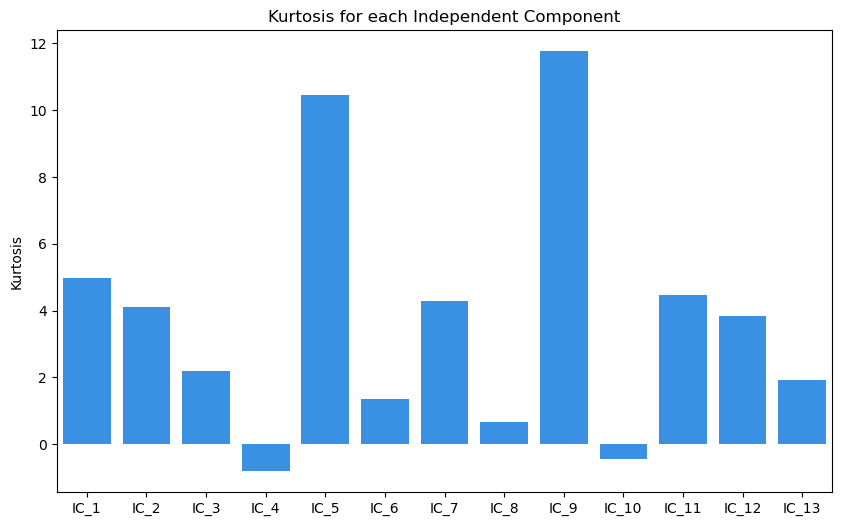

In [7]:
from scipy.stats import kurtosis

# Compute kurtosis for each IC
kurt_values = [kurtosis(ica_df[col]) for col in ica_df.columns]

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x=[f'IC_{i+1}' for i in range(n_components)], y=kurt_values, color='dodgerblue')
plt.title('Kurtosis for each Independent Component')
plt.ylabel('Kurtosis')
plt.show()

/Users/yrizvi/miniconda3/envs/ML/lib/python3.9/site-packages/sklearn/decomposition/_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


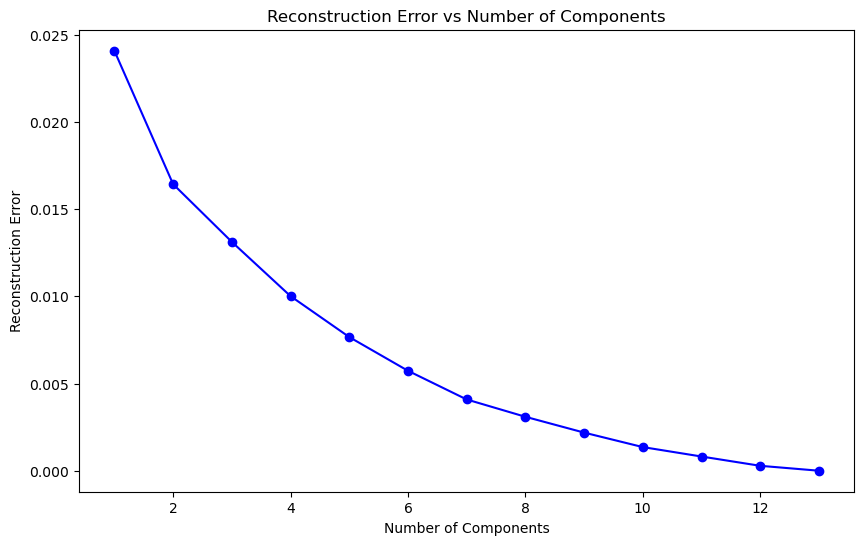

In [8]:
reconstruction_errors = []

# We loop from 1 to the number of features in the dataset
for n in range(1, X_train.shape[1] + 1):
    ica = FastICA(n_components=n, random_state=42, max_iter=2000, tol=0.01)
    X_train_ICA = ica.fit_transform(X_train)
    X_train_ICA_reconstructed = ica.inverse_transform(X_train_ICA)
    error = mean_squared_error(X_train, X_train_ICA_reconstructed)
    reconstruction_errors.append(error)

# Plot the reconstruction errors
plt.figure(figsize=(10, 6))
plt.plot(range(1, X_train.shape[1] + 1), reconstruction_errors, marker='o', color='b')
plt.title('Reconstruction Error vs Number of Components')
plt.xlabel('Number of Components')
plt.ylabel('Reconstruction Error')
plt.show()